In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

### Data

- $I$ is the set of all courses for a specified term 
- $J$ is the set of all classrooms available
- $K$ is the set of all timeslots in 2-hour standard intervals from 8 am to 10 pm, that exist for the courses in the specified term.
- $W$ is the set from Monday to Friday.
- $m_{i}$ is the required seating for class $i$
- $n_{j}$ is the maximum capacity for room $j$
- $A_{i}$ is the preference of whether courses are after 10 am and before 6 pm, $i \in I, A_{i} \in \{1,2,3,4\}$
- $B_{i}$ is the preference of whether courses prefer Monday and Wednesday is satisfied, $i \in I, B_{i} \in \{1,2,3,4\}$
- $C_{i}$ is the preference of whether courses prefer Tuesday and Thursday, $i \in I, C_{i} \in \{1,2,3,4\}$
- $s_{i}$ is the credits or the slots needed for course $i$, $i \in I$

### Decision Variables

- $x_{ijkw}$ is our binary decision variable which equals to 1 when course $i$ is taught in classroom $j$ at timeslot $k$ of weekday w and 0 otherwise.
- $h_{i}$ is whether course slots are the same on Monday and Wednesday or Tuesday and Thursday, $i \in I$
- $a_{i}$ is whether the preference of whether courses are after 10 am and before 6 pm is satisfied, $i \in I$
- $b_{i}$ is whether the preference of whether courses prefer Monday and Wednesday is satisfied, $i \in I$
- $c_{i}$ is whether the preference of whether courses prefer Tuesday and Thursday is satisfied, $i \in I$


### Objective and Constraints

$$\begin{aligned}
\text{Maximize} && 4\times \sum_{i \in I, k \in K, j \in J} \frac{x_{ijk}}{s_{i}}\big(\frac{m_{ik}}{n_{jk}}\big)+&\sum_{i \in I} a_{i}A_{i}+\sum_{i \in I} b_{i}B_{i}+\sum_{i \in I} c_{i}C_{i}+ \sum_{i \in I} 4\times h_{i}\\
\text{subject to:} \\
\text{Room Capcity} && m_{i}x_{ijkw} & \le n_{j}x_{ijkw} \qquad  \text{for all }  i \in I, j \in J, k \in K , w \in W \\
\text{Room Time Conflict} && \sum_{i \in I} x_{ijkw} & \le 1 \qquad \qquad \text{for all }  j \in J, k \in K, w \in W \\
\text{Course Times} && \sum_{k \in K, w \in W, j \in J} x_{ijkw} & = s_{i} \qquad \qquad \text{for all } i \in I \\
\text{Course Room Fix}&& h_{i}=1\quad when \quad x_{ijkw} & = x_{ijk(w+2)} \qquad  \text{for all }  i \in I, j \in J, w \in \{1,2\}, k \in K \\
\text{Preference A}&& a_{i}=1 \quad when \quad  \sum_{j,k \in \{2,3,4,5\},w} x_{ijkw} &= s_{i} \qquad  \text{for all }  i \in I \\
\text{Preference B}&& a_{i}=1 \quad when \quad  \sum_{j,k,w=1} x_{ijkw}+x_{ijk(w+2)}&= s_{i}  \qquad  \text{for all }  i \in I \\
\text{Preference C}&& a_{i}=1 \quad when \quad  \sum_{j,k,w=2} x_{ijkw}+x_{ijk(w+2)} &= s_{i} \qquad  \text{for all }  i \in I \\
\text{Binary} && x_{ijk} & \in \{0,1\}
\end{aligned}$$

### Preparation of Schedule Data

In [547]:
# Read schedule data
df_schedule=pd.read_csv('schedule_2015_to_2019.csv')

In [548]:
df_schedule

,cancelled,date_of_cancellation,term,course,section,title,mode,units,level,department,...,second_instructor_uid,second_room,seats_offered,reg_count,adj_reg,wait_count,total_tuition_units,classroom_capacity,cap_remaining_seats,classroom_remaining_seats
0,True,NaN,20153,NaN,14025,External Financial Reporting Issues,C,4.0,NaN,NaN,...,NaN,NaN,42,24,NaN,NaN,96.0,46.0,18.0,22.0
1,False,NaN,20153,ACCT-370,14025,External Financial Reporting Issues,C,4.0,NaN,ACCT,...,NaN,NaN,42,24,NaN,NaN,96.0,46.0,18.0,22.0
2,True,NaN,20153,NaN,14026,External Financial Reporting Issues,C,4.0,NaN,NaN,...,NaN,NaN,42,40,NaN,NaN,160.0,46.0,2.0,6.0
3,False,NaN,20153,ACCT-370,14026,External Financial Reporting Issues,C,4.0,NaN,ACCT,...,NaN,NaN,42,40,NaN,NaN,160.0,46.0,2.0,6.0
4,True,NaN,20153,NaN,14027,External Financial Reporting Issues,C,4.0,NaN,NaN,...,NaN,NaN,42,42,NaN,NaN,168.0,46.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,False,NaN,20192,MKT-533,16530,Branding Strategy,C,3.0,G,MKT,...,NaN,NaN,56,38,38.0,0.0,114.0,60.0,18.0,22.0
7437,False,NaN,20192,MOR-557,16694,Strategy and Organization Consulting,C,3.0,G,MOR,...,NaN,NaN,48,42,42.0,0.0,126.0,60.0,6.0,18.0
7438,False,NaN,20192,MOR-554,16700,Leading Innovation and Change,C,3.0,G,MOR,...,NaN,NaN,61,33,33.0,0.0,99.0,60.0,28.0,27.0
7439,False,NaN,20192,MOR-569,16716,Negotiation and Deal-Making,C,3.0,G,MOR,...,NaN,NaN,54,39,39.0,0.0,117.0,60.0,15.0,21.0


### Preparation of Tables and Plots

In [549]:
# Separate data of canceled course and terms
df=df_schedule[['cancelled','term']]

In [550]:
# Summary table of  canceled courses each term by running the code here and above
df.groupby('term').sum().astype(int)

,cancelled
term,
20153,553
20161,617
20162,45
20163,646
20171,613
20172,45
20173,0
20181,0
20182,3


In [551]:
# summary table of total course records, canceled courses, and percentage of canceled courses by running this code
df.groupby('term').agg(['count','sum',np.mean])

cancelled                 
          count    sum      mean
term                            
20153      1111  553.0  0.497750
20161      1228  617.0  0.502443
20162        88   45.0  0.511364
20163      1250  646.0  0.516800
20171      1177  613.0  0.520816
20172        89   45.0  0.505618
20173       595    0.0  0.000000
20181       609    0.0  0.000000
20182        50    3.0  0.060000
20183       607    4.0  0.006590
20191       588    6.0  0.010204
20192        49    2.0  0.040816

In [552]:
# the total cancelled courses throught the records, offering data to the summary table of the total canceled records and the percentage in all data entry records 
df.cancelled.sum()

2534

In [553]:
# total percentage of canceled course, offering data to the summary table of the total canceled records and the percentage in all data entry records 
df.cancelled.sum()/df.cancelled.count()

0.3405456255879586

In [4]:
# separate courses not canceled
df_set=df_schedule[df_schedule['cancelled']==False]

In [29]:
df_set.groupby('term')['classroom_remaining_seats'].sum().astype(int)

term
20153     6944
20161     8119
20162      876
20163     9296
20171    10926
20172      704
20173     9671
20181    10317
20182      814
20183     8980
20191     8703
20192      813
Name: classroom_remaining_seats, dtype: int32

In [45]:
# running the code below comes the table of the total classroom seat not utilized and the percentage in total classroom seats for each semester
df_table=df_set.groupby('term').apply(lambda x: [x['classroom_remaining_seats'].sum(),x['classroom_remaining_seats'].sum()/x['classroom_capacity'].sum()])

In [48]:
df_tables=pd.DataFrame(list(df_table.values),index=df_table.index,columns=['Total','Percentage'])

In [50]:
# running the code above and here comes the table of the total classroom seat not utilized and the percentage in total classroom seats for each semester
df_tables

,Total,Percentage
term,,
20153,6944.0,0.291483
20161,8119.0,0.339835
20162,876.0,0.323009
20163,9296.0,0.297968
20171,10926.0,0.327067
20172,704.0,0.313307
20173,9671.0,0.283250
20181,10317.0,0.302631
20182,814.0,0.336642


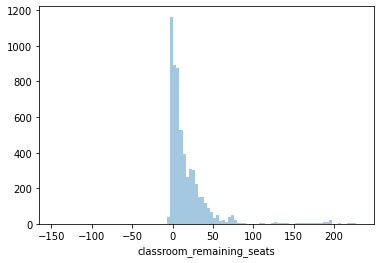

In [60]:
# running this code produce the distribution of unutilized classroom seats for all courses
# we judge from the distribution and the exploration of large and minus empty space that they are forced to waste or exceed space.
sns.distplot(df_schedule['classroom_remaining_seats'].dropna(),bins=100,kde=False)

In [54]:
df_schedule['classroom_remaining_seats'].unique()

array([  22.,    6.,    4.,   80.,   17.,    5.,   76.,    0.,  125.,
         11.,  127.,    7.,    3.,    2.,   13.,   nan,   14.,   34.,
         21.,  196.,   23.,  221.,   10.,  161.,   18.,   37.,   39.,
         30.,   26.,   19.,    8.,   54.,   25.,   29.,   42.,   67.,
         44.,   16.,   41.,   20.,   27.,   15.,   49.,    9.,   35.,
         43.,   31.,   38.,  175.,  206.,    1.,  188.,   74.,   75.,
         71.,   69.,   51.,  195.,   50.,   70.,  171.,   32.,   12.,
         45.,   57.,   -3.,   48.,   24.,   33.,   36.,   46.,   56.,
         40.,   64.,   47.,  105.,  177.,  168.,  158.,   55.,   52.,
         28.,   66.,   -7.,  154.,   90.,   77.,   86.,   78.,   73.,
         84.,  157.,  224.,  155.,  185.,   62.,   72.,   -1.,   58.,
         68.,  167.,  110.,  166.,   53.,  202.,  179.,  180.,   83.,
         59.,  132.,  129.,  160.,   61.,   60.,  218.,  211.,  139.,
        141.,  108.,  111.,  193.,  192.,  164.,  165.,  133.,  -17.,
        -14.,  219.,

In [57]:
# Overcrowded course appeared.
df_schedule[df_schedule['classroom_remaining_seats']==-146]

,cancelled,date_of_cancellation,term,course,section,title,mode,units,level,department,...,second_instructor_uid,second_room,seats_offered,reg_count,adj_reg,wait_count,total_tuition_units,classroom_capacity,cap_remaining_seats,classroom_remaining_seats
5353,False,NaN,20173,GSBA-552,15860,Problem Solving and Decision Making: An Integr...,C,3.0,G,MOR,...,NaN,NaN,226,223,223.0,0.0,669.0,77.0,3.0,-146.0


### Production of sample input

In [11]:
# we use records of Fall 2016 as samples
df_20163=df_set[df_set['term']==20163]

In [12]:
df_20163

,cancelled,date_of_cancellation,term,course,section,title,mode,units,level,department,...,second_instructor_uid,second_room,seats_offered,reg_count,adj_reg,wait_count,total_tuition_units,classroom_capacity,cap_remaining_seats,classroom_remaining_seats
2428,False,NaN,20163,ACCT-370,14026,External Financial Reporting Issues,C,4.0,NaN,ACCT,...,NaN,NaN,51,50,NaN,NaN,200.0,60.0,1.0,10.0
2430,False,NaN,20163,ACCT-370,14027,External Financial Reporting Issues,C,4.0,NaN,ACCT,...,NaN,NaN,51,48,NaN,NaN,192.0,60.0,3.0,12.0
2432,False,NaN,20163,ACCT-370,14029,External Financial Reporting Issues,L,0.0,NaN,ACCT,...,NaN,NaN,135,98,NaN,NaN,0.0,269.0,37.0,171.0
2434,False,NaN,20163,ACCT-371,14041,Introduction to Accounting Systems,C,4.0,NaN,ACCT,...,NaN,NaN,54,54,NaN,NaN,216.0,60.0,0.0,6.0
2436,False,NaN,20163,ACCT-371,14042,Introduction to Accounting Systems,C,4.0,NaN,ACCT,...,NaN,NaN,52,48,NaN,NaN,192.0,60.0,4.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3666,False,NaN,20163,WRIT-340,66784,Advanced Writing,C,4.0,NaN,BUCO,...,NaN,NaN,19,17,NaN,NaN,68.0,20.0,2.0,3.0
3668,False,NaN,20163,WRIT-340,66785,Advanced Writing,C,4.0,NaN,BUCO,...,NaN,NaN,19,19,NaN,NaN,76.0,20.0,0.0,1.0
3671,False,NaN,20163,WRIT-340,66787,Advanced Writing,C,4.0,NaN,BUCO,...,NaN,NaN,19,19,NaN,NaN,76.0,20.0,0.0,1.0
3673,False,NaN,20163,WRIT-340,66789,Advanced Writing,C,4.0,NaN,BUCO,...,NaN,NaN,19,18,NaN,NaN,72.0,20.0,1.0,2.0


In [22]:
# retain common two class and one class courses
df_20163_prep=df_20163[df_20163['units']<=4]

In [23]:
# convert units to explicit course slots
df_20163_prep.loc[:,'units']=df_20163_prep.units.map(lambda x: 1 if x<=2 else 2)

In [25]:
# extract relevant information
df_20163_prep=df_20163_prep.loc[:,['course','section','units','seats_offered']]

In [27]:
# output table, the random preferences are handed to Excel functions
df_20163_prep.to_csv('sample_input.csv',index=False)

### Output Results

In [481]:
# the following are the code of optimize.py, please refer to the documentation of optimization files.

import gurobipy as gp
courses=pd.read_excel('Mini.xlsx',sheet_name='Courses')
classrooms=pd.read_excel('Mini.xlsx',sheet_name='Classrooms')

In [529]:
mod=gp.Model()

In [530]:
X=mod.addVars(len(courses),len(classrooms),7,5,vtype=gp.GRB.BINARY)

In [531]:
H=mod.addVars(len(courses),vtype=gp.GRB.BINARY)
A=mod.addVars(len(courses),vtype=gp.GRB.BINARY)
B=mod.addVars(len(courses),vtype=gp.GRB.BINARY)
C=mod.addVars(len(courses),vtype=gp.GRB.BINARY)

In [532]:
m=courses['seats_offered']
n=classrooms['Size']
s=courses['units']
a=courses['A']
b=courses['B']
c=courses['C']

In [533]:
I=len(courses)
J=len(classrooms)

In [534]:
# Here util represents Leverage of Utility pref represents Leverage of Preference, pref_bi represents Preferences Fulfilled, as part of the summary table of optimization results
util=4 * gp.quicksum(X[i, j, k, w] * m[i] / (s[i] * n[j])
                                       for i in range(I) for j in range(J)
                                       for k in range(7) for w in range(5))

pref=gp.quicksum(a[i] * A[i] + b[i] * B[i] + c[i] * C[i] + 4*H[i]
                           for i in range(I))

pref_bi= gp.quicksum(A[i] + B[i] + C[i] + H[i]
                           for i in range(I))

obj = mod.setObjective(4 * gp.quicksum(X[i, j, k, w] * m[i] / (s[i] * n[j])
                                       for i in range(I) for j in range(J)
                                       for k in range(7) for w in range(5)) +
                       gp.quicksum(
                           a[i] * A[i] + b[i] * B[i] + c[i] * C[i] + 4*H[i]
                           for i in range(I)),sense=gp.GRB.MAXIMIZE)

In [535]:
x1=mod.addConstrs(m[i]*X[i,j,k,w]<=n[j]*X[i,j,k,w] for i in range(I) for j in range(J)
                                       for k in range(7) for w in range(5))

In [536]:
x2 = mod.addConstrs(
    gp.quicksum(X[i, j, k, w] for i in range(I)) <= 1 for j in range(J)
    for k in range(7) for w in range(5))

In [537]:
x3 = mod.addConstrs(
    gp.quicksum(X[i, j, k, w] for j in range(J) for k in range(7)
                for w in range(5)) == s[i] for i in range(I))

In [538]:
temp1=mod.addVars(I,J,7,2)
temp1_c=mod.addVars(I,J,7,2)
temp1_r=mod.addVars(I,J,7,2)

mod.addConstrs(temp1[i, j, k, w] == X[i, j, k, w] - X[i, j, k , w+2]
               for i in range(I) for j in range(J) for k in range(7)
               for w in range(2))

mod.addConstrs(temp1_c[i, j, k, w]==gp.abs_(temp1[i, j, k, w])
               for i in range(I) for j in range(J) for k in range(7)
               for w in range(2))

mod.addConstrs(1-temp1_r[i, j, k, w]==temp1_c[i, j, k, w]
               for i in range(I) for j in range(J) for k in range(7)
               for w in range(2))

mod.addConstrs(H[i]==gp.and_(temp1_r[i,j,k,w] for j in range(J)
            for k in range(7) for w in range(2)) for i in range(I))

{0: <gurobi.GenConstr *Awaiting Model Update*>,
 1: <gurobi.GenConstr *Awaiting Model Update*>,
 2: <gurobi.GenConstr *Awaiting Model Update*>,
 3: <gurobi.GenConstr *Awaiting Model Update*>,
 4: <gurobi.GenConstr *Awaiting Model Update*>,
 5: <gurobi.GenConstr *Awaiting Model Update*>,
 6: <gurobi.GenConstr *Awaiting Model Update*>,
 7: <gurobi.GenConstr *Awaiting Model Update*>,
 8: <gurobi.GenConstr *Awaiting Model Update*>,
 9: <gurobi.GenConstr *Awaiting Model Update*>,
 10: <gurobi.GenConstr *Awaiting Model Update*>,
 11: <gurobi.GenConstr *Awaiting Model Update*>,
 12: <gurobi.GenConstr *Awaiting Model Update*>,
 13: <gurobi.GenConstr *Awaiting Model Update*>}

In [539]:
temp3=mod.addVars(I,J,3,5)

mod.addConstrs(temp3[i,j,0,w]==1-X[i,j,0,w] for i in range(I) for j in range(J) for w in range(5))

mod.addConstrs(temp3[i,j,1,w]==1-X[i,j,5,w] for i in range(I) for j in range(J) for w in range(5))
mod.addConstrs(temp3[i,j,2,w]==1-X[i,j,6,w] for i in range(I) for j in range(J) for w in range(5))

mod.addConstrs(A[i] == gp.and_(temp3[i, j, k, w] for j in range(J)
                               for k in range(3) for w in range(5))
               for i in range(I))

{0: <gurobi.GenConstr *Awaiting Model Update*>,
 1: <gurobi.GenConstr *Awaiting Model Update*>,
 2: <gurobi.GenConstr *Awaiting Model Update*>,
 3: <gurobi.GenConstr *Awaiting Model Update*>,
 4: <gurobi.GenConstr *Awaiting Model Update*>,
 5: <gurobi.GenConstr *Awaiting Model Update*>,
 6: <gurobi.GenConstr *Awaiting Model Update*>,
 7: <gurobi.GenConstr *Awaiting Model Update*>,
 8: <gurobi.GenConstr *Awaiting Model Update*>,
 9: <gurobi.GenConstr *Awaiting Model Update*>,
 10: <gurobi.GenConstr *Awaiting Model Update*>,
 11: <gurobi.GenConstr *Awaiting Model Update*>,
 12: <gurobi.GenConstr *Awaiting Model Update*>,
 13: <gurobi.GenConstr *Awaiting Model Update*>}

In [540]:
temp4=mod.addVars(I,J,7,3)

mod.addConstrs(temp4[i,j,k,0]==1-X[i,j,k,1] for i in range(I) for j in range(J) for k in range(7))
mod.addConstrs(temp4[i,j,k,1]==1-X[i,j,k,3] for i in range(I) for j in range(J) for k in range(7))
mod.addConstrs(temp4[i,j,k,2]==1-X[i,j,k,4] for i in range(I) for j in range(J) for k in range(7))
mod.addConstrs(B[i] == gp.and_(temp4[i, j, k, w] for j in range(J)
                               for k in range(7) for w in range(3))
               for i in range(I))

{0: <gurobi.GenConstr *Awaiting Model Update*>,
 1: <gurobi.GenConstr *Awaiting Model Update*>,
 2: <gurobi.GenConstr *Awaiting Model Update*>,
 3: <gurobi.GenConstr *Awaiting Model Update*>,
 4: <gurobi.GenConstr *Awaiting Model Update*>,
 5: <gurobi.GenConstr *Awaiting Model Update*>,
 6: <gurobi.GenConstr *Awaiting Model Update*>,
 7: <gurobi.GenConstr *Awaiting Model Update*>,
 8: <gurobi.GenConstr *Awaiting Model Update*>,
 9: <gurobi.GenConstr *Awaiting Model Update*>,
 10: <gurobi.GenConstr *Awaiting Model Update*>,
 11: <gurobi.GenConstr *Awaiting Model Update*>,
 12: <gurobi.GenConstr *Awaiting Model Update*>,
 13: <gurobi.GenConstr *Awaiting Model Update*>}

In [541]:
temp5=mod.addVars(I,J,7,3)

mod.addConstrs(temp5[i,j,k,0]==1-X[i,j,k,0] for i in range(I) for j in range(J) for k in range(7))
mod.addConstrs(temp5[i,j,k,1]==1-X[i,j,k,2] for i in range(I) for j in range(J) for k in range(7))
mod.addConstrs(temp5[i,j,k,2]==1-X[i,j,k,4] for i in range(I) for j in range(J) for k in range(7))
mod.addConstrs(C[i] == gp.and_(temp5[i, j, k, w] for j in range(J)
                               for k in range(7) for w in range(3))
               for i in range(I))

{0: <gurobi.GenConstr *Awaiting Model Update*>,
 1: <gurobi.GenConstr *Awaiting Model Update*>,
 2: <gurobi.GenConstr *Awaiting Model Update*>,
 3: <gurobi.GenConstr *Awaiting Model Update*>,
 4: <gurobi.GenConstr *Awaiting Model Update*>,
 5: <gurobi.GenConstr *Awaiting Model Update*>,
 6: <gurobi.GenConstr *Awaiting Model Update*>,
 7: <gurobi.GenConstr *Awaiting Model Update*>,
 8: <gurobi.GenConstr *Awaiting Model Update*>,
 9: <gurobi.GenConstr *Awaiting Model Update*>,
 10: <gurobi.GenConstr *Awaiting Model Update*>,
 11: <gurobi.GenConstr *Awaiting Model Update*>,
 12: <gurobi.GenConstr *Awaiting Model Update*>,
 13: <gurobi.GenConstr *Awaiting Model Update*>}

In [542]:
# Optimization starts
mod.optimize()

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 1729 rows, 1932 columns and 4046 nonzeros
Model fingerprint: 0x82eb9bcf
Model has 252 general constraints
Variable types: 1386 continuous, 546 integer (546 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [8e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 1118 rows and 1428 columns
Presolve time: 0.03s
Presolved: 611 rows, 504 columns, 3322 nonzeros
Variable types: 0 continuous, 504 integer (504 binary)
Found heuristic solution: objective 110.3636364

Root relaxation: objective 1.439260e+02, 584 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  143.92596    0  175  110.36364  143.92596  30.4%     -    0s
H    0     0                     122.3636364  143.92596  17.6%     -    0s
H    0    

In [496]:
# Organize output table
pos=[]

for i in range(I):
    for j in range(J):
        for k in range(7):
            for w in range(5):
                if X[i,j,k,w].X==1:
                    pos.append([i,j,k,w])

In [497]:
final=pd.DataFrame(data=pos,columns=['course','classroom','slot','weekday'])

In [498]:
# the numerical format table 
final

,course,classroom,slot,weekday
0,0,0,3,4
1,1,0,4,4
2,2,0,3,1
3,3,0,6,4
4,4,0,2,4
5,5,0,1,4
6,6,0,4,0
7,6,0,4,2
8,7,0,1,0
9,7,0,1,2


In [499]:
# convert numeric to text
slots=['8am','10am','12pm','2pm','4pm','6pm','8pm']
weekdays=['Mon','Tue','Wed','Thu','Fri']

In [500]:
final['course']=final['course'].map(lambda x: courses.loc[x,'course']+','+str(courses.loc[x,'section']))

In [501]:
final['classroom']=final['classroom'].map(lambda x: classrooms.loc[x,'Room'])
final['slot']=final['slot'].map(lambda x: slots[x])
final['weekday']=final['weekday'].map(lambda x: weekdays[x])

In [503]:
# text table of optimization
final.to_csv（

,course,classroom,slot,weekday
0,"DSO-401,16212",JKP112,2pm,Fri
1,"DSO-401,16214",JKP112,4pm,Fri
2,"DSO-401,16215",JKP112,2pm,Tue
3,"DSO-401,16218",JKP112,8pm,Fri
4,"DSO-401,16219",JKP112,12pm,Fri
5,"DSO-402,16220",JKP112,10am,Fri
6,"DSO-427,16222",JKP112,4pm,Mon
7,"DSO-427,16222",JKP112,4pm,Wed
8,"DSO-435,16230",JKP112,10am,Mon
9,"DSO-435,16230",JKP112,10am,Wed


In [504]:
# convert table to time schedule
tables=pd.DataFrame(np.zeros((7,5)),index=slots,columns=weekdays)

In [505]:
tables=tables.astype(str)

In [506]:
for i in range(len(final)):
    tables.iloc[pos[i][2],pos[i][3]]=final.loc[i,'course']

In [507]:
# This is the table of JKP 112 to be compared with 
tables

,Mon,Tue,Wed,Thu,Fri
8am,0.0,0.0,0.0,0.0,0.0
10am,"DSO-435,16230","ACCT-550T,14230","DSO-435,16230","ACCT-550T,14230","DSO-402,16220"
12pm,"BAEP-452,14381","ACCT-430,14146","BAEP-452,14381","ACCT-430,14146","DSO-401,16219"
2pm,"ACCT-430,14144","DSO-401,16215","ACCT-430,14144",0.0,"DSO-401,16212"
4pm,"DSO-427,16222","ACCT-581,14269","DSO-427,16222","ACCT-581,14269","DSO-401,16214"
6pm,0.0,0.0,0.0,0.0,0.0
8pm,0.0,"BAEP-452,14382",0.0,"BAEP-452,14382","DSO-401,16218"


In [477]:
# we use a small portion of Fall 2016 and JKP 112 as samples in the report
df=df_schedule[df_schedule['term']==20163]

In [478]:
df_jkp=df[df['first_room']=='JKP112']

In [480]:
df_jkp[df_jkp['cancelled']==False]

,cancelled,date_of_cancellation,term,course,section,title,mode,units,level,department,...,second_instructor_uid,second_room,seats_offered,reg_count,adj_reg,wait_count,total_tuition_units,classroom_capacity,cap_remaining_seats,classroom_remaining_seats
2548,False,NaN,20163,ACCT-560T,14231,Tax Theory and Ethics,C,3.0,NaN,ACCT,...,NaN,NaN,50,50,NaN,NaN,150.0,77.0,0.0,27.0
2552,False,NaN,20163,ACCT-561T,14237,Income Tax of Corporations and Their Shareholders,C,3.0,NaN,ACCT,...,NaN,NaN,54,51,NaN,NaN,153.0,77.0,3.0,26.0
3154,False,NaN,20163,FBE-555,15431,Investment Analysis and Portfolio Management,C,3.0,NaN,FBE,...,NaN,NaN,77,43,NaN,NaN,129.0,77.0,34.0,34.0
3246,False,NaN,20163,GSBA-528,15722,Marketing Management,C,3.0,NaN,MKT,...,NaN,NaN,58,52,NaN,NaN,156.0,77.0,6.0,25.0
3304,False,NaN,20163,GSBA-524,15858,Managerial Statistics,C,3.0,NaN,DSO,...,NaN,NaN,70,65,NaN,NaN,195.0,77.0,5.0,12.0
3363,False,NaN,20163,DSO-530,16272,Applied Modern Statistical Learning Methods,C,3.0,NaN,DSO,...,NaN,NaN,50,47,NaN,NaN,141.0,77.0,3.0,30.0
3369,False,NaN,20163,DSO-547,16276,Designing Spreadsheet-Based Business Models,C,3.0,NaN,DSO,...,NaN,NaN,42,38,NaN,NaN,114.0,77.0,4.0,39.0
3385,False,NaN,20163,DSO-510,16301,Business Analytics,C,3.0,NaN,DSO,...,NaN,NaN,75,73,NaN,NaN,219.0,77.0,2.0,4.0
3437,False,NaN,20163,MKT-512,16522,Customer Insights and Analysis,C,3.0,NaN,MKT,...,NaN,NaN,54,52,NaN,NaN,156.0,77.0,2.0,25.0
3445,False,NaN,20163,MKT-533,16531,Branding Strategy,C,1.5,NaN,MKT,...,NaN,NaN,77,52,NaN,NaN,78.0,77.0,25.0,25.0


In [543]:
# the values of utility leverage
util.getValue()

24.363636363636378

In [544]:
# the values of preference leverage
pref.getValue()

109.0

In [545]:
# the values of preference fulfilled
pref_bi.getValue()

34.0